In [1]:
import numpy as np
import networkx as nx
import graph_generator as gg
import graph_visualiser as gv
import importlib

In [ ]:
importlib.reload(gg)
importlib.reload(gv)

## Zad 3. Analiza obwodu elektrycznego

#### Funkcja znajdująca natężenie w poszczególnych częściach obwodu z użyciem praw Kirchoffa
Funkcja przyjmuje na wejściu obiekt typy nx.Graph(), a także parę wierzchołków s oraz t, między którymi została przyłożona siła elektromotoryczna E.
Niczego nie zwraca, modyfikuje jedynie wartość natężenia na każdej krawędzi.( Każda krawędź grafu jest reprezentowana przez obiekt Edge, która posiada między innymi atrybut current opisujący natężenie)

Przyjmuje, że umowny kierunek prądu zawsze prowadzi z wierzchołka o mniejszym indeksie do wierzchołka o większym indeksie( wierzchołki grafu są opisywane przez kolejne liczby naturalne począwszy od zera). Dzięki temu nie muszę przechowywać nigdzie informacji o przyjętym umównym kierunku prądu na krawędzi, gdyż obiekt Edge, przechowuje informacje o wierzchołkach z którymi dana krawędź jest incydentna.

Do wyznaczenia cykli prostych użyłem funkcji z biblioteki networkx cycle_basis(), która przyjmuje graf i zwraca "cycle basis", czyli minimalny zbiór cykli prostych takich, że każdy cykl w grafie da się przedstawić jako sumę cykli z tego zbioru.

Układ równań rozwiązuje z użyciem funkcji numpy.linalg.solve(), lecz funkcja ta nie rozwiązuje nadokreśłonych układów równań, więc najpierw muszę równanie macierzowe pomnożyć lewostronnie przez macierz transponowaną do macierzy układu.

In [3]:
def kirchoff(g, s, t, e):
    def add_sum_component(v1, v2):
        edge = g[v1][v2]['edge']
        if (v1, v2) == (s, t) or (v1, v2) == (t, s):
            if v1 < v2:
                B[eq_no] -= e
            else:
                B[eq_no] += e
        else:
            if v1 < v2:
                A[eq_no][edge.index] += edge.resistance
            else:
                A[eq_no][edge.index] -= edge.resistance

    n = g.number_of_nodes()
    m = g.number_of_edges()

    cycle_basis = nx.cycle_basis(g)
    no_of_eq = n + len(cycle_basis)
    A = np.zeros((no_of_eq, m))
    B = np.zeros(no_of_eq)

    eq_no = 0
    for cycle in cycle_basis:
        for i in range(1, len(cycle)):
            add_sum_component(cycle[i-1], cycle[i])
        add_sum_component(cycle[-1], cycle[0])
        eq_no += 1

    for v in range(n):
        for neighbor in g.neighbors(v):
            edge = g[v][neighbor]['edge']
            if v < neighbor:
                A[eq_no][edge.index] += 1
            else:
                A[eq_no][edge.index] -= 1
        eq_no += 1

    transposed = A.T
    ans = np.linalg.solve(np.matmul(transposed, A), np.matmul(transposed, B))
    for a, b in g.edges:
        edge = g[a][b]['edge']
        edge.current = ans[edge.index]

#### Znajdowanie natężeń metodą potencjałów węzłowych

Funkcja przyjmuje te same argumenty co kirchoff() i tak samo nic nie zwraca tylko modyfikuje dany graf.

Umowny kierunek prądu wyznaczam tak samo jak w kirchoffie. Potencjał 0 przyjmuje w wierzchołku s. Wtedy wierzchołek t musi mieć potencjał E.
Powstała macierz układu jest kwadratowa, więc można ją rozwiązać z użyciem np.linalg.solve. Natężenia dzieląc różnicę potencjałów na danej krawędzi przez jej opór.


In [4]:
def nodal_potentials(g, s, t, e):
    n = g.number_of_nodes()
    A = np.zeros((n, n))
    B = np.zeros(n)
    A[s][s] = 1
    B[s] = e
    A[t][t] = 1
    B[t] = 0

    for v in range(n):
        if v != s and v != t:
            for neighbor in g.neighbors(v):
                edge = g[v][neighbor]['edge']
                A[v][v] += 1/edge.resistance
                A[v][neighbor] -= 1/edge.resistance

    potentials = np.linalg.solve(A, B)
    for a, b in g.edges:
        edge = g[a][b]['edge']
        if a < b:
            edge.current = (potentials[a] - potentials[b]) / edge.resistance
        else:
            edge.current = (potentials[b] - potentials[a]) / edge.resistance

Funkcja sprawdza czy suma natężeń w każdym węźle jest bliska zeru

In [5]:
def check_currents(g, s, t):
    eps = pow(10, -12)
    for v in range(g.number_of_nodes()):
        if v != s and v != t:
            current_sum = 0
            for neighbor in g.neighbors(v):
                if v < neighbor:
                    current_sum += g[v][neighbor]['edge'].current
                else:
                    current_sum -= g[v][neighbor]['edge'].current
            if abs(current_sum) > eps:
                return False
    return True

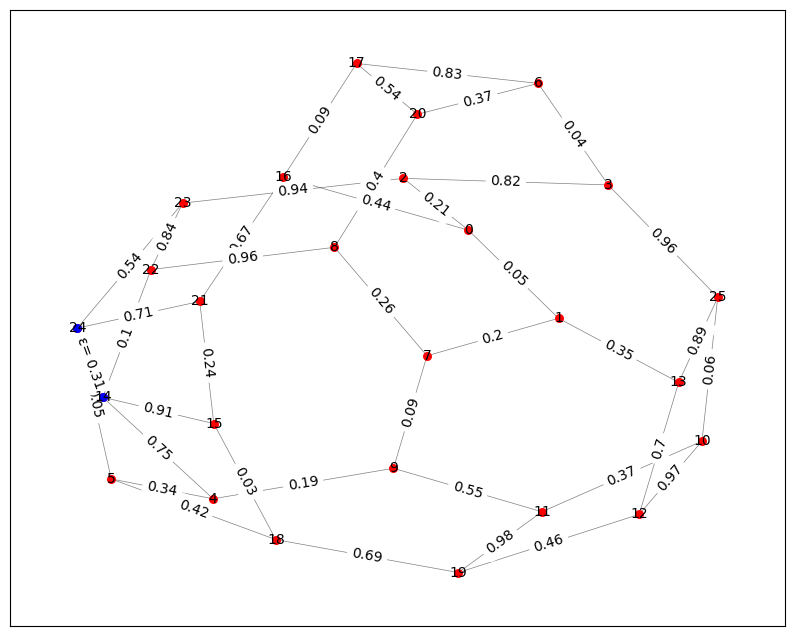

In [9]:
G, source, target, E = gg.load_graph('cubic_small')
gv.draw_with_resistance(G, source, target, E, small=True)

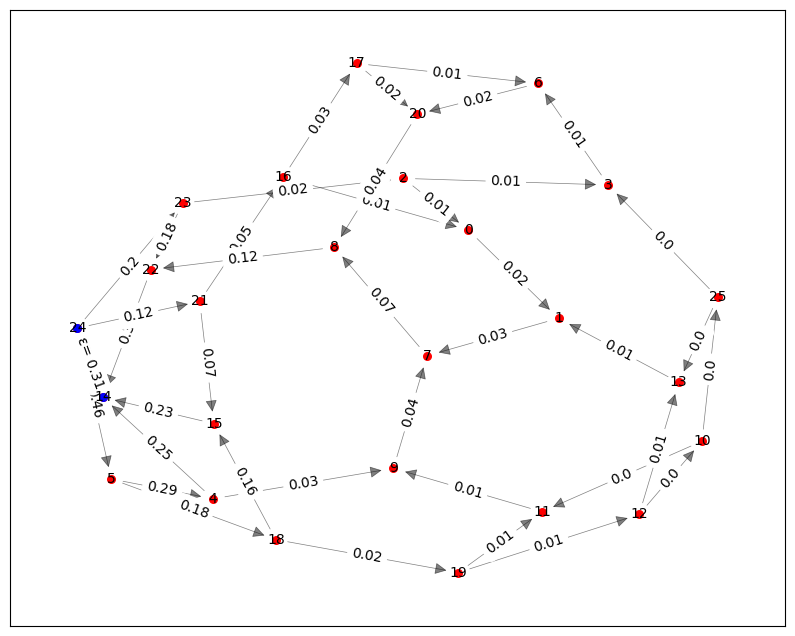

In [10]:
kirchoff(G, source, target, E)
gv.draw_with_current(G, source, target, E, small=True)